In [ ]:
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np
import torchvision.models as models
import torch.nn as nn
import torch
import torchvision
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torch.utils.data import Subset

# A100 GPU 최적화 설정
torch.backends.cudnn.benchmark = True  # 최적의 알고리즘 자동 선택
torch.backends.cuda.matmul.allow_tf32 = True  # TF32 활성화 (A100 특화)
torch.backends.cudnn.allow_tf32 = True



def get_CIFAR10_data_loader(ratio:int = 1.0)-> tuple[DataLoader, DataLoader]:
    """
    CIFAR10데이터셋을 가져오는 함수 (전체 훈련셋 : 50000개, 전체 테스트셋 : 10000개)

    Args:
        ratio: 전체 데이터셋 대비 비중

    Returns:
        (train_loader, test_loader)
    """
    TRAINSET_COUNT = 50000

    # 1. 전처리 정의 (GPU 친화적)
    transform_train = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),  # 데이터 증강
        transforms.RandomCrop(224, padding=4),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225])
    ])

    transform_test = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225])
    ])

    # 데이터셋 로드
    trainset = torchvision.datasets.CIFAR10(
        root='./data', train=True, download=True, transform=transform_train
    )

    # 데이터 서브셋 생성
    indices = list(range(int(TRAINSET_COUNT * ratio)))
    subset_trainset = Subset(trainset, indices)

    testset = torchvision.datasets.CIFAR10(
        root='./data', train=False, download=True, transform=transform_test
    )

    # 3. DataLoader 생성 (A100 최적화)
    # A100은 대용량 배치를 효율적으로 처리
    trainloader = torch.utils.data.DataLoader(
        subset_trainset,
        batch_size=64,  # A100에 최적화된 큰 배치 사이즈
        shuffle=True,
        num_workers=12,  # A100 시스템의 CPU 코어 활용
        pin_memory=True,  # GPU 전송 속도 향상
        prefetch_factor=4,  # 미리 가져올 배치 수
        persistent_workers=True  # Worker 재사용
    )

    testloader = torch.utils.data.DataLoader(
        testset,
        batch_size=512,  # 평가 시 더 큰 배치
        shuffle=False,
        num_workers=8,
        pin_memory=True,
        prefetch_factor=2,
        persistent_workers=True
    )

    return trainloader, testloader

def get_custom_resnet50(class_count:int = 10) -> models.ResNet:
    """
    resnet의 분류클래스를 변경하여 리턴하는 함수

    Args:
        클래스의 개수

    Returns:
        ResNet모델
    """
    model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

    # 모델의 마지막 완전연결층 레이어 변경
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, class_count)

    return model

def get_custom_vgg16(class_count:int = 10) -> models.vgg16:
    """
    VGG16의 분류클래스를 변경하여 리턴하는 함수

    Args:
        클래스의 개수

    Returns:
        VGG16모델
    """
    model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
    in_features = model.classifier[6].in_features
    model.classifier[6] = nn.Linear(in_features, 10)

    return model


def test_model(model, loss_function, test_loader, device):
    """
    모델을 테스트 하는 함수

    Args:
        model : 테스트 모델,
        loss_function : 손실함수
        test_loader : 테스트 데이터셋,
        device : 테스트를 수행할 디바이스

    Returns:
        학습 오차율, 정확도(%)
    """
    model.to(device)
    model.eval() # 👈 모델을 평가 모드로 설정
    total = 0
    correct = 0
    with torch.no_grad(): # 👈 기울기 계산 비활성화
        running_loss = 0.0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            loss = loss_function(outputs, labels)
            running_loss += loss.item()
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total

    return (running_loss, accuracy)


def train_model(model, optimizer, loss_function, train_loader, test_loader, device):
  """
  모델을 훈련 하는 함수

  Args:
      model : 테스트 모델,
      optimizer : 옵티마이저,
      loss_function : 손실함수,
      train_loader : 훈련 데이터셋
      test_loader : 테스트 데이터셋,
      device : 훈련을 수행할 디바이스

  Returns:
      list : 각 에포크마다 학습 오차율, 정확도(%)
  """

  model.to(device)

  print("Starting Training...")
  num_epochs = 5  # 👈 전체 데이터셋을 5번 반복 학습 (시간이 오래 걸릴 수 있습니다)
  result = []
  for epoch in range(num_epochs):
      # Dropout, BatchNorm 등이 학습 모드로 동작합니다.
      model.train()

      # train_loader에서 배치(batch) 단위로 데이터를 가져옵니다.
      for i, (images, labels) in enumerate(train_loader):
          # 1. 데이터를 디바이스로 이동
          images = images.to(device, non_blocking=True)
          labels = labels.to(device, non_blocking=True)

          # 2. (필수) 옵티마이저의 기울기(gradient)를 0으로 초기화
          optimizer.zero_grad(set_to_none=True)

          # 3. 순전파(Forward pass): 모델에 이미지를 입력하여 출력(로짓) 계산
          outputs = model(images)

          # 4. 손실(Loss) 계산
          loss = loss_function(outputs, labels)

          # 5. (필수) 역전파(Backward pass): 손실에 대한 기울기 계산
          loss.backward()

          # 6. (필수) 옵티마이저 실행: 계산된 기울기를 바탕으로 가중치 업데이트
          optimizer.step()

      # --- 한 Epoch이 끝날 때마다 테스트 정확도 평가 ---
      epoch_loss, epoch_accuracy = test_model(model, loss_function, test_loader, device)
      result.append((epoch_loss, epoch_accuracy))
      print(f"에포크 {epoch+1} 학습 완료, 정확도 : {epoch_accuracy}, 손실 : {epoch_loss}")

  return result


def make_loss_accuracy_graph(losses:list[tuple[str, list[float]]], accrucies:list[tuple[str, float]]):
    """
    손실, 정확도 그래프를 그려주는 함수

    Args:
        losses : (훈련조건, 훈련결과) 를 담은 리스트
        accrucies : (훈련조건, 훈련결과) 를 담은 리스트

    Returns:
        없음
    """

    fig, axes = plt.subplots(nrows=1, ncols=2)

    # 손실그래프 생성
    for loss in losses:
        label, values = loss
        axes[0].plot([i for i in range (1, len(values)+1)], values, label=label)

    axes[0].set_title("loss graph")
    axes[0].set_xlabel("epoch")
    axes[0].set_ylabel("loss")
    axes[0].grid(True, linestyle='--', alpha=0.6)
    axes[0].legend()


    # 정확도 그래프 생성
    for accuracy in accrucies:
        label, values = accuracy
        axes[1].plot([i for i in range (1, len(values)+1)], values, label=label)

    axes[1].set_title("accuracy graph")
    axes[1].set_xlabel("epoch")
    axes[1].set_ylabel("accuracy(%)")
    axes[1].grid(True, linestyle='--', alpha=0.6)
    axes[1].legend()

    fig.tight_layout() # 서브플롯들이 겹치지 않도록 간격조절
    plt.show()

# 이미지 출력하기
def print_img(data, label):
    img_grid = data * 0.5 + 0.5
    np_grid = img_grid.numpy()
    np_grid_rgb = np.transpose(np_grid,(1,2,0)) # 기존 (채널, 높이, 너비) -> (높이, 너비, 채널)

    print(label)

    plt.figure(figsize=(10, 2)) # 가로 10, 세로 2 인치
    plt.imshow(np_grid_rgb)
    plt.axis('off') # 축 정보 끄기
    plt.show()




1. 사전 훈련된 ResNet 모델을 불러와 새로운 이미지 데이터셋(예: CIFAR-10, 간단한 custom dataset)을 분류하세요.
1-1. 학습 없이 바로 inference를 실행한 뒤 성능을 측정하고, 추가 학습(fine-tuning)을 수행했을 때 성능 변화를 비교하세요.
1-2. (연구 보고서 필수 조건)
- Pre-trained 모델을 사용할 때 얻는 이점(빠른 수렴, 적은 데이터 요구량 등)
- 학습 전후 성능 비교표 및 시각화
- ResNet 구조적 특징(Residual Block)이 성능에 기여하는 방식 설명

Files already downloaded and verified
50000
Files already downloaded and verified
ship


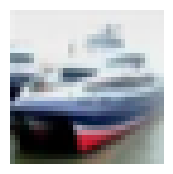

torch.Size([64, 10])
tensor([1, 4, 9, 5, 0, 2, 9, 5, 0, 9, 6, 9, 2, 1, 2, 0, 6, 2, 6, 4, 6, 4, 8, 8,
        1, 7, 1, 5, 1, 7, 8, 2, 3, 0, 1, 8, 6, 2, 9, 7, 5, 3, 6, 1, 5, 3, 2, 1,
        3, 0, 4, 6, 0, 6, 5, 8, 2, 2, 0, 1, 3, 5, 8, 3])
64
손실 : 2.5255119800567627, 정확도 : 0.078125


In [ ]:
import numpy as np
import torch
import torchvision.models as models
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

train_loader, test_loader = get_CIFAR10_data_loader(ratio=0.1)
model = get_custom_resnet50(class_count=10)

loss_function = nn.CrossEntropyLoss()
# optimizer = optim.AdamW(
#     model.parameters(),
#     lr=1e-3,
#     weight_decay=1e-4  # 정규화
# )
optimizer = optim.Adam(model.parameters(), lr=0.001)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
no_train = [test_model(model, loss_function, test_loader, device)] * 5
train = train_model(model, optimizer, loss_function, train_loader, test_loader, device)

# 그래프 생성
losses = [("no_train", list(map(lambda t:t[0], no_train))), ("train", list(map(lambda t:t[0], train)))]
accrucies = [("no_train", list(map(lambda t:t[1], no_train))), ("train", list(map(lambda t:t[1], train)))]
make_loss_accuracy_graph(losses=losses ,accrucies=accrucies)

2.이미지 데이터셋(예: CIFAR-10, 간단한 custom dataset)과 사전 훈련된 VGG16 모델을 가져와 전이 학습을 수행하세요.
2-1. Feature Extraction 단계만 사용한 경우와, Fine Tuning을 적용한 경우를 비교하여 성능 변화를 분석하세요.
2-2. (연구 보고서 필수 조건)
- 두 실험의 성능 비교표와 학습 곡선(손실, 정확도)
- Feature Extraction과 Fine Tuning의 차이 분석
- Fine Tuning 시 레이어를 얼마나 동결/해제했는지와 그 이유 설명

In [ ]:
import numpy as np
import torch
import torchvision.models as models
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import matplotlib.pyplot as plt
from torch.cuda.amp import autocast, GradScaler
import torch.backends.cudnn as cudnn

# 학습데이터 생성
train_loader, test_loader = get_CIFAR10_data_loader(ratio=0.1)


##################### 풀-파인튜닝 ######################
model = get_custom_vgg16(class_count=10)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
full_tuning_train = train_model(model, optimizer, loss_function, train_loader, test_loader, device)
#####################################################


##################### 특징추출 ######################
model = get_custom_vgg16(class_count=10)
loss_function = nn.CrossEntropyLoss()

# features 전체 동결
for param in model.features.parameters():
    param.requires_grad = False
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
feature_extraction_train = train_model(model, optimizer, loss_function, train_loader, test_loader, device)
#####################################################

# 파인튜닝-특징추출 비교 그래프 생성
losses = [("full_tuning", list(map(lambda t:t[0], full_tuning_train))), ("feature_extraction", list(map(lambda t:t[0], feature_extraction_train)))]
accrucies = [("full_tuning", list(map(lambda t:t[1], full_tuning_train))), ("feature_extraction", list(map(lambda t:t[1], feature_extraction_train)))]
make_loss_accuracy_graph(losses=losses ,accrucies=accrucies)



# 각 레이어를 하나씩 동결해제 하면서 파인튜닝 성능비교

# Block 1 & 2: [0] ~ [9]

# Block 3: [10] ~ [16]

# Block 4: [17] ~ [23]

# Block 5: [24] ~ [30]

##################### Block 1,2 동결 ######################
model = get_custom_vgg16(class_count=10)
loss_function = nn.CrossEntropyLoss()

# features 전체 동결
for i, module in enumerate(model.features):
    if i <= 9:  # Block 1,2 동결
        for param in module.parameters():
            param.requires_grad = False
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
partial_345_train = train_model(model, optimizer, loss_function, train_loader, test_loader, device)
#####################################################

##################### Block 1,2,3 동결 ######################
model = get_custom_vgg16(class_count=10)
loss_function = nn.CrossEntropyLoss()

# features 전체 동결
for i, module in enumerate(model.features):
    if i <= 16:  # Block 1,2,3 동결
        for param in module.parameters():
            param.requires_grad = False
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
partial_45_train = train_model(model, optimizer, loss_function, train_loader, test_loader, device)
#####################################################

##################### Block 1,2,3,4 동결 ######################
model = get_custom_vgg16(class_count=10)
loss_function = nn.CrossEntropyLoss()

# features 전체 동결
for i, module in enumerate(model.features):
    if i <= 23:  # Block 1,2,3,4 동결
        for param in module.parameters():
            param.requires_grad = False
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
partial_5_train = train_model(model, optimizer, loss_function, train_loader, test_loader, device)
#####################################################

# 파인튜닝-특징추출 비교 그래프 생성
losses = [
          ("full_tuning", list(map(lambda t:t[0], full_tuning_train))),
          ("partial_345", list(map(lambda t:t[0], partial_345_train))),
          ("partial_45", list(map(lambda t:t[0], partial_45_train))),
          ("partial_5", list(map(lambda t:t[0], partial_5_train)))
         ]
accrucies = [
          ("full_tuning", list(map(lambda t:t[1], full_tuning_train))),
          ("partial_345", list(map(lambda t:t[1], partial_345_train))),
          ("partial_45", list(map(lambda t:t[1], partial_45_train))),
          ("partial_5", list(map(lambda t:t[1], partial_5_train)))
         ]
make_loss_accuracy_graph(losses=losses ,accrucies=accrucies)




3. 동일한 데이터셋에서 ResNet과 VGG16을 각각 학습시켜 성능을 비교하세요.
3-1. 모델 파라미터 수, 학습 속도, 최종 성능(정확도, F1-score 등)을 모두 고려하여 비교 분석하세요.
3-2. (연구 보고서 필수 조건)
- 모델별 구조 차이(Residual vs 단순 Conv stack)
- 학습 곡선과 최종 성능 지표 비교
- 어떤 상황에서 ResNet, VGG16 각각을 선택하는 것이 합리적인지 해석

In [ ]:
import numpy as np
import torch
import torchvision.models as models
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

train_loader, test_loader = get_CIFAR10_data_loader(ratio=1.0)

##################### VGG16학습 ######################
model = get_custom_vgg16(class_count=10)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vgg16_train = train_model(model, optimizer, loss_function, train_loader, test_loader, device)
#####################################################

##################### resnet50학습 ######################
model = get_custom_resnet50(class_count=10)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
resnet50_train = train_model(model, optimizer, loss_function, train_loader, test_loader, device)
#####################################################

# 그래프 생성
losses = [("vgg16_train", list(map(lambda t:t[0], vgg16_train))), ("resnet50_train", list(map(lambda t:t[0], resnet50_train)))]
accrucies = [("vgg16_train", list(map(lambda t:t[1], vgg16_train))), ("resnet50_train", list(map(lambda t:t[1], resnet50_train)))]
make_loss_accuracy_graph(losses=losses ,accrucies=accrucies)

4. 가상 데이터셋 또는 소규모 실제 데이터셋을 생성한 뒤, GridSearch와 RandomSearch 기법으로 하이퍼파라미터 튜닝을 진행하세요.
4-1. 학습률, 배치 크기, 은닉층 크기 등의 조합을 실험하고 최적 조합을 찾으세요.
4-2. (연구 보고서 필수 조건)
- 각 탐색 방식의 시도 횟수와 걸린 시간 비교
- 최적 조합과 그 성능 기록
- GridSearch와 RandomSearch가 가진 한계와 활용 상황 비교

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt

def make_moons_dataset(n_samples:int, noise:float, test_ratio:float)->tuple[torch.tensor, torch.tensor, torch.tensor, torch.tensor]:
  """
  moons데이터셋을 생성하는 함수

  Args:
      ratio: 전체 데이터셋 대비 비중

  Returns:
      (X_train, y_train, X_test, y_test)
  """

  X, y = make_moons(n_samples=n_samples, noise=noise, random_state=42)

  X_train, X_test, y_train, y_test = train_test_split(
      X, y,
      test_size=test_ratio,
      random_state=42
  )

  X_train = torch.tensor(X, dtype=torch.float32)
  y_train = torch.tensor(y, dtype=torch.float32).view(-1, 1)
  X_test = torch.tensor(X, dtype=torch.float32)
  y_test = torch.tensor(y, dtype=torch.float32).view(-1, 1)

  return X_train, y_train, X_test, y_test

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        """
        MLP모델 생성자

        Args:
            input_size : 입력층의 노드 개수
            hidden_size : 은닉층의 노드 개수
            output_size : 출력층의 노드 개수

        Returns:
            (train_loader, test_loader)
        """
        super(MLP, self).__init__()

        # 입력 -> 은닉층1
        self.hidden_layer1 = nn.Linear(input_size, hidden_size)

        # 은닉층1 -> 은닉층2
        self.hidden_layer2 = nn.Linear(hidden_size, hidden_size)

        # 은닉층2 -> 출력층
        self.output_layer = nn.Linear(hidden_size, output_size)

        # 은닉층의 활성화 함수
        self.activation = nn.ReLU()


    def forward(self, x):
        """순전파 (Forward Propagation)"""
        # 1. 입력 -> 은닉층1
        z1 = self.hidden_layer1(x)
        a1 = self.activation(z1) # 활성화함수 적용

        # 2. 은닉층1 -> 은닉층2
        z2 = self.hidden_layer2(a1)
        a2 = self.activation(z2) # 활성화함수 적용

        # 3. 은닉층2 -> 출력층
        z3 = self.output_layer(a2)
      #  a3 = self.output_activation(z3)
        return z3

def train_model(epoch:int, model, optimizer, loss_function, device):
    """
    모델을 훈련 하는 함수

    Args:
        model : 테스트 모델,
        optimizer : 옵티마이저,
        loss_function : 손실함수,
        device : 훈련을 수행할 디바이스

    Returns:
        list : 각 에포크마다 학습 오차율, 정확도(%)
    """

    model.to(device)

    X_train, y_train, X_test, y_test = make_moons_dataset(n_samples=1000, noise=0.3, test_ratio=0.3)

    X_train = X_train.to(device)
    y_train = y_train.to(device)
    X_test = X_test.to(device)
    y_test = y_test.to(device)

    print("Starting Training...")
    result = []
    for epoch in range(epoch):
      model.train()

      predictions = model(X_train)

      # 손실(오차) 계산
      loss = loss_function(predictions, y_train)

      #  그래디언트 초기화
      optimizer.zero_grad()

      # 그래디언트 계산
      loss.backward()

      # 가중치 업데이트
      #  그래디언트로 가중치 업데이트
      optimizer.step()

      # 에포크 종료 후 모델 평가
      model.eval()
      with torch.no_grad(): # .no_grad()는 그래디언트 계산을 비활성화 (평가 시에는 필요 없음)
          final_predictions = model(X_test)

          # 손실계산
          test_loss = loss_function(final_predictions, y_test).item()

          # 정확도 계산
          rounded_predictions = (final_predictions > 0.5).int()
          test_accuracy = (rounded_predictions == y_test).float().mean()
          test_accuracy = f"{test_accuracy.item() * 100:.2f}"

          result.append((test_loss, test_accuracy))



    return result


import matplotlib.pyplot as plt
import numpy as np

def make_search_graph(result: dict):
    """
    손실, 정확도 그래프를 그려주는 함수 (Scatter Plot)

    Args:
        result (dict): {훈련 식별자(str 또는 int): (손실, 정확도) 튜플} 형태의 딕셔너리
                       예: {'Trial 1': (0.5, 0.8), 'Trial 2': (0.3, 0.9)}
    Returns:
        없음
    """

    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 7))

    # 1. 산점도 데이터를 딕셔너리 '값' (Value)에서 추출
    # result.values()는 [(loss1, acc1), (loss2, acc2), ...] 형태
    losses = list(map(lambda t: t[0], result.values()))
    accuracies = list(map(lambda t: t[1], result.values()))

    # 2. 산점도 그리기
    axes.scatter(losses, accuracies,
                 color='blue',
                 marker='o',
                 s=50,
                 alpha=0.7,
                 label='Trial Point') # 범례를 위해 label 추가

    i = 5
    for trial_name, (loss, acc) in result.items():

        # plt.annotate(주석 텍스트, (x좌표, y좌표))
        axes.annotate(
            trial_name,            # 주석 텍스트: 훈련 이름/식별자 (Key)
            (loss, acc),           # 주석이 붙을 (X, Y) 좌표: Value 튜플
            textcoords="offset points",
            #xytext=(5, 5),          # (5, 5) 픽셀만큼 오른쪽 위로 이동
            ha='left',              # 텍스트의 수평 정렬
            fontsize=10,            # 폰트 크기 조정
            fontweight='bold',
            xytext=(float(loss) + 1+(i/5), float(acc) + 10+i),  # 주석을 데이터와 떨어진 좌표에 위치
            arrowprops=dict(facecolor='black', shrink=0.05, width=0.5, headwidth=4),
        )
        i+=5

    # 4. 그래프 꾸미기
    axes.set_title("Hyperparameter Search Graph (Loss vs. Accuracy)")
    axes.set_xlabel("Loss")
    axes.set_ylabel("Accuracy")
    axes.grid(True, linestyle='--', alpha=0.6)
    axes.legend()

    fig.tight_layout()
    plt.show()


In [ ]:

from itertools import product # Grid Search를 위한 모든 조합 생성
import time
import random
import numpy as np

# GridSearch와 RandomSearch 기법으로 하이퍼파라미터 튜닝
# 학습률, 에포크 수, 은닉층 크기

# 하이퍼 파라미터 정의
param_grid = {
    'lr': [0.01, 0.001],
    'epoch': [32, 128],
    'num_units': [64, 128]
}

########### GridSearch기법으로 학습
# 모든 조합 생성
keys = param_grid.keys()
combinations = list(product(*param_grid.values()))

start_time = time.time()

grid_result = {}
for combination in combinations :
  lr, epoch, num_units = combination
  model = MLP(2, num_units, 1)

  loss_function = nn.BCEWithLogitsLoss()
  optimizer = optim.Adam(model.parameters(), lr=lr)

  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  result = train_model(epoch=epoch, model=model, optimizer=optimizer, loss_function=loss_function, device=device)

  grid_result[f"lr: {lr}, epoch: {epoch}, num_units: {num_units}"] = result[-1]

end_time = time.time()

execution_time = end_time - start_time

print(f"총 실행 시간: {execution_time:.6f}초")
print(grid_result)

# 그래프 생성
make_search_graph(grid_result)


########### RandomSearch기법으로 학습

def sample_hyperparameters(param_space):
    """정의된 공간에서 하이퍼파라미터를 무작위로 샘플링합니다."""
    sampled_params = []

    for name, spec in param_grid.items():
        low = spec[0]
        high = spec[1]
        sampled_params.append(random.uniform(low, high))

    return sampled_params


start_time = time.time()

random_result = {}
for i in range(8):
    # 1. 하이퍼파라미터 무작위 샘플링
    current_params = sample_hyperparameters(param_grid)
    lr, epoch, num_units = current_params
    model = MLP(2, int(num_units), 1)

    loss_function = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    result = train_model(epoch=int(epoch), model=model, optimizer=optimizer, loss_function=loss_function, device=device)

    random_result[f"lr: {lr}, epoch: {int(epoch)}, num_units: {int(num_units)}"] = result[-1]

end_time = time.time()

execution_time = end_time - start_time

print(f"총 실행 시간: {execution_time:.6f}초")

print(grid_result)
print(random_result)

# 그래프 생성
make_search_graph(random_result)
